# Load data

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(0, 1),
    ]
)

# Load the training and test datasets
train_data = datasets.MNIST("data", train=True, download=True, transform=transform)
test_data = datasets.MNIST("data", train=False, download=True, transform=transform)

# Create data loaders to load the data in batches
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

X_train = train_data.data.float().unsqueeze(1)
X_test = test_data.data.float().unsqueeze(1)

# binarize
# X_train[X_train > 0] = 1
# X_test[X_test > 0] = 1

X_train.shape, X_test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

# Learn to display things

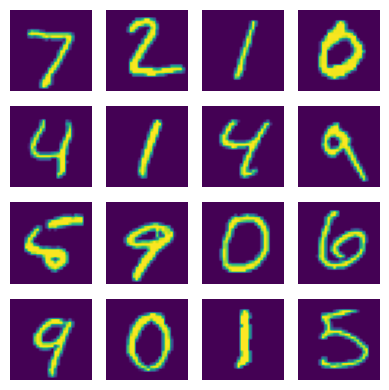

In [2]:
import matplotlib.pyplot as plt


def plot_image_grid(images):
    num_images = len(images)
    rows = 4
    cols = 4

    fig, axes = plt.subplots(rows, cols, figsize=(4, 4))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < num_images:
                axes[i, j].imshow(images[index])
                axes[i, j].axis("off")
            else:
                axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()


plot_image_grid(X_test[:100].squeeze(1))

(20, 64, 64, 1)
MoviePy - Building file test.gif with imageio.


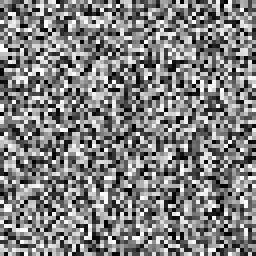

In [3]:
import numpy as np


def into_gif(frames: np.ndarray, scale: int = 4):
    from moviepy.editor import ImageSequenceClip

    assert len(frames.shape) == 4
    print(frames.shape)
    if frames.shape[-1] == 1:
        frames = frames.repeat(3, axis=-1)

    frames = np.repeat(frames, scale, axis=1).repeat(scale, axis=2)

    clip = ImageSequenceClip(list(frames), fps=10)
    clip.write_gif("test.gif", fps=10)


def show():
    from IPython.display import display, Image

    return Image("test.gif")


frames = np.random.randint(256, size=[20, 64, 64, 1], dtype=np.uint8)
into_gif(frames)
show()

In [4]:
class ForwardProcess:
    def __init__(self, betas: torch.Tensor):
        self.beta = betas

        self.alphas = 1.0 - betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=-1)

    def get_x_t(
        self, x_0: torch.Tensor, t: torch.LongTensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Forward diffusion process given the unperturbed sample x_0.

        Args:
            x_0: Original, unperturbed samples.
            t: Target timestamp of the diffusion process of each sample.

        Returns:
            Noise added to original sample and perturbed sample.
        """
        eps_0 = torch.randn_like(x_0).to(x_0)
        alpha_bar = self.alpha_bar[t, None]
        mean = (alpha_bar**0.5) * x_0
        std = (1.0 - alpha_bar) ** 0.5

        return (eps_0, mean + std * eps_0)

In [5]:
T = 100  # Number of diffusion steps
betas = torch.linspace(0.0, 0.99, T)
betas = betas.flatten()
fp = ForwardProcess(betas=betas)

In [6]:
import numpy as np
from tqdm.notebook import tqdm

x = X_train[:100].clone()
xt = []
for idx, t in tqdm(enumerate(range(T))):
    x_t = (
        fp.get_x_t(x.reshape(100, -1), t=torch.LongTensor([t] * 100))[1]
        .numpy()
        .reshape(100, 1, 28, 28)
    )
    xt.append(x_t)
xt = np.hstack(xt)
xt.shape

0it [00:00, ?it/s]

(100, 100, 28, 28)

(100, 28, 28, 1)
MoviePy - Building file test.gif with imageio.


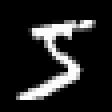

In [7]:
into_gif(xt[0][..., None])
show()

For example, degradation of an image over 100 diffusion steps

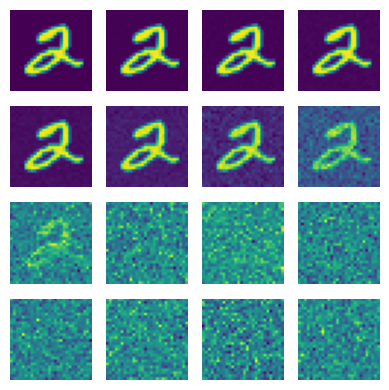

In [8]:
plot_image_grid(xt[5][::5])

# Defining the model 

In [9]:
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426

import torch
from torch import nn
import torch.nn.functional as F
from torchtyping import TensorType as TT
import math


def positional_embeding_matrix(
    position_id: int, d_out: int
) -> TT["position_id", "out_dim"]:  # noqa: F821
    """Generates a pre-computed tensor with positional embeddings.

    Returns
    -------
    torch.Tensor
        embedings tensor; `i` position contains vector for `if token is at position "i"`
    """
    assert d_out % 2 == 0, f"d_out should be even, got {d_out=}"

    position: TT["position_id", 1] = torch.arange(position_id).unsqueeze(-1)
    div_term: TT["d_out // 2"] = (
        torch.arange(0, d_out, 2) * (-math.log(10_000.0) / d_out)
    ).exp()
    pe = torch.zeros(position_id, d_out)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe


class PositionalEmbedder(nn.Module):
    def __init__(self, num_possible_tokens: int, d_embed: int):
        super().__init__()
        self.num_possible_tokens = num_possible_tokens
        self.d_embed = d_embed
        emb: TT["num_possible_tokens", "d_embed"] = positional_embeding_matrix(
            num_possible_tokens, d_embed
        )
        self.register_buffer("emb", emb)

    def forward(
        self,
        tokens: TT["b", "l", torch.long],  # noqa: F821
    ) -> TT["b", "l", "self.d_embed", torch.float]:  # noqa: F821
        return self.emb[tokens]


class UNetWithTime(nn.Module):
    def __init__(
        self,
        max_T=100,
        in_channels=1,
        n_classes=2,
        depth=4,
        wf=4,
        padding=True,
        batch_norm=True,
        up_mode="upconv",
        device="cuda",
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597

        Using the default arguments will yield the exact version used
        in the original paper

        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super().__init__()
        assert up_mode in ("upconv", "upsample")
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(
                    prev_channels,
                    2 ** (wf + i),
                    padding,
                    batch_norm,
                )
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(
                    prev_channels,
                    2 ** (wf + i),
                    up_mode,
                    padding,
                    batch_norm,
                )
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

        self.te = PositionalEmbedder(max_T, 28 * 28)
        self.device = device
        self.to(device)

    def forward(self, x, t):
        x = x.to(self.device)
        te = self.te(t).to(self.device).reshape(-1, 1, 28, 28).to(self.device)
        x = x + te
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == "upconv":
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == "upsample":
            self.up = nn.Sequential(
                nn.Upsample(mode="bilinear", scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

# Add some ⚡

In [10]:
torch.max(x[:10], axis=0)[0].shape

torch.Size([1, 28, 28])

In [11]:
def scale_to_255(nchw: torch.Tensor) -> torch.Tensor:
    nchw = nchw + torch.min(nchw, dim=0, keepdim=True)[0] + 1
    nchw = nchw / torch.max(nchw, axis=0, keepdim=True)[0]
    nchw = (nchw * 255).int()
    nchw = nchw - nchw.min(axis=0, keepdim=True)[0]
    return nchw

In [12]:
import lightning as L


class Denoiser(L.LightningModule):
    def __init__(self, model, max_T: int, forward_diffusion: ForwardProcess):
        super().__init__()
        self.model = model.to(self.device)
        self.max_T = max_T
        self.fp = forward_diffusion

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, _ = batch
        n = x.shape[0]
        t = torch.randint(low=0, high=self.max_T, size=(n,))
        t[t > self.current_epoch] = self.current_epoch

        with torch.no_grad():
            eps, x_t = self.fp.get_x_t(x.reshape(n, -1).to("cpu"), t.to("cpu"))
        eps = eps.reshape(n, 1, 28, 28).to(self.device)
        x_t = x_t.reshape(n, 1, 28, 28).to(self.device)

        eps_pred = self.model(x_t, t)
        loss = F.mse_loss(eps_pred, eps)

        # do the logging
        img = scale_to_255(eps_pred[:5].to("cpu").detach())
        print(img.min(), img.max(), img.shape, img.dtype)
        self.logger.experiment.add_image(
            "generated_images",
            img,
            dataformats="NCHW",
            global_step=self.current_epoch,
        )

        self.log("train_loss", loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        n = x.shape[0]
        t = torch.randint(low=0, high=self.max_T, size=(n,))
        t[t > self.current_epoch] = self.current_epoch

        with torch.no_grad():
            eps, x_t = self.fp.get_x_t(x.reshape(n, -1).to("cpu"), t.to("cpu"))
        eps = eps.reshape(n, 1, 28, 28).to(self.device)
        x_t = x_t.reshape(n, 1, 28, 28).to(self.device)

        eps_pred = self.model(x_t, t)
        loss = F.mse_loss(eps_pred, eps)

        self.log("test_loss", loss.item())

In [13]:
T = 100  # Number of diffusion steps
betas = torch.linspace(0.0, 0.99, T)
fp = ForwardProcess(betas=betas)

base_model = UNetWithTime(
    in_channels=1, n_classes=1, depth=3, padding=True, wf=4, max_T=T
)
denoiser = Denoiser(model=base_model, max_T=T, forward_diffusion=fp)

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger(".")
trainer = L.Trainer(
    accelerator="cuda",
    logger=logger,
)

batch_size = 1024
trainer.fit(
    model=denoiser,
    train_dataloaders=torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=True
    ),
    val_dataloaders=torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, shuffle=True
    ),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | UNetWithTime | 117 K 
---------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.470     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 